laspy version: 2.2.0
numpy version: 1.22.4
rasterio version: 1.3.6
scipy version: 1.7.3
cv2 version: 4.6.0
------------------------------------
The EPSG code of the DSM file is: 2968
DSM exists, skip step A-C
Step 0: DSM pre-processing done
Step 1: Breakline-map delineation done
RuleB
Step 2: Object identification done
Step 3: DTM generation done


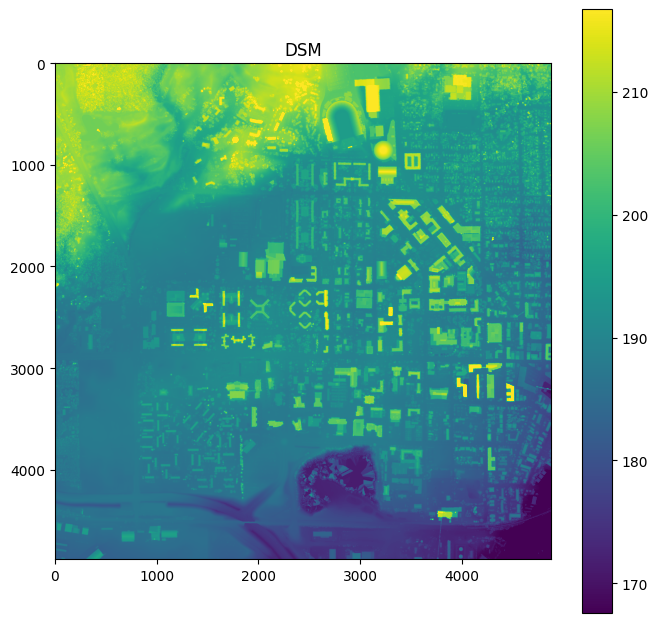

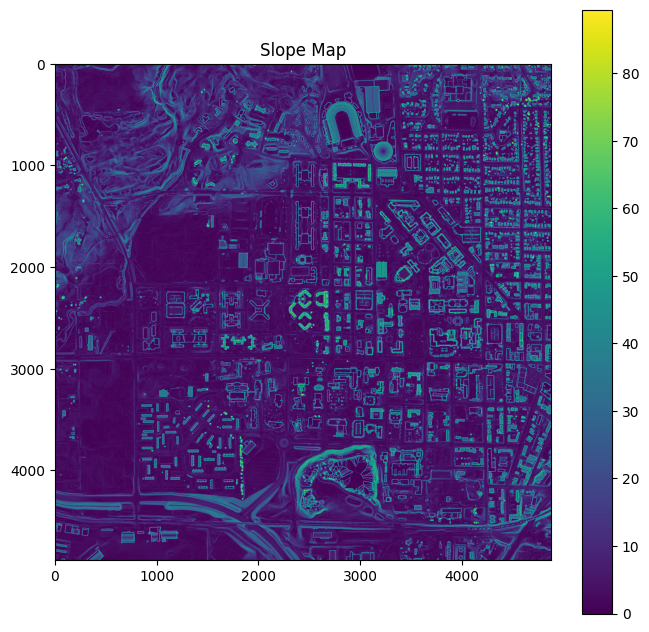

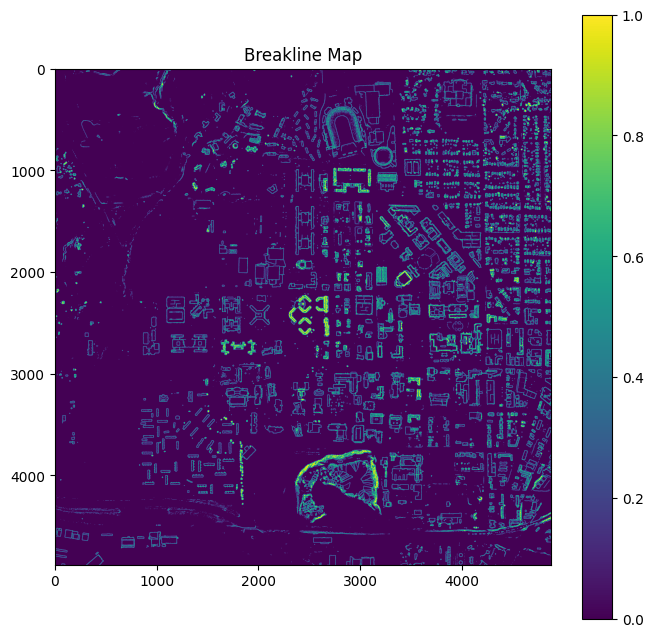

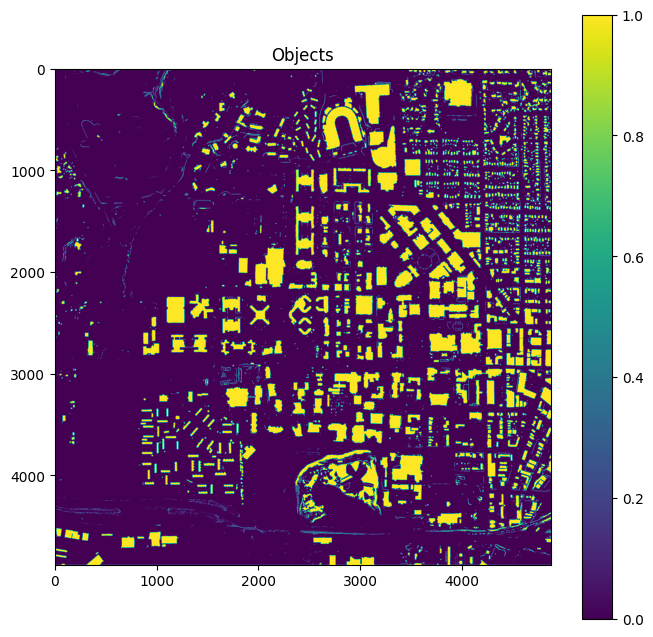

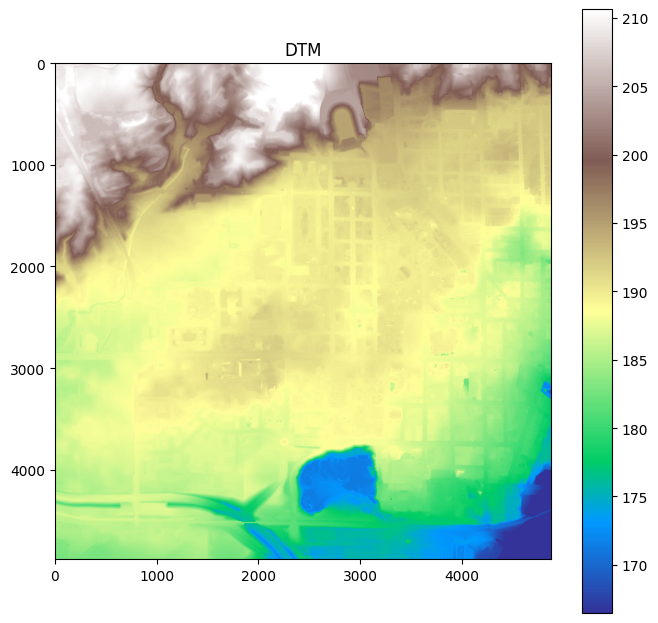

In [1]:
'''

Please refer to the publication "An Object-based Ground Filtering of Airborne LiDAR Data for Large-Area DTM Generation" (2023) by Hunsoo Song & Jinha Jung.

Sample data (either DSM or LAS) is available for download:

- DSM file: [DSM_Purdue.tif](https://lidar.digitalforestry.org/outbox/DSM_Purdue.tif)
- LAS file: [LAS_Purdue.las](https://lidar.digitalforestry.org/outbox/LAS_Purdue.las)

'''

# Import libraries
import laspy
import numpy as np
import rasterio
from rasterio.transform import from_origin
import cv2
import matplotlib.pyplot as plt
import scipy
from scipy.ndimage import median_filter, minimum_filter
from scipy.signal import convolve2d as conv2
from scipy import interpolate

# Check versions
print("laspy version:", laspy.__version__) # laspy is only needed if one starts from the lasfiles
print("numpy version:", np.__version__)
print("rasterio version:", rasterio.__version__)
print("scipy version:", scipy.__version__)
print("cv2 version:", cv2.__version__)
print("------------------------------------")

slope_threshold = 45
target_resolution = 0.5 # Default is 0.5m resolution

DSM_exist = True
RuleA = False

def sobel_filter(img):
    Gx = np.array([[1.0, 0.0, -1.0], [2.0, 0.0, -2.0], [1.0, 0.0, -1.0]])
    Gy = np.array([[1.0, 2.0, 1.0], [0.0, 0.0, 0.0], [-1.0, -2.0, -1.0]])
    gx = conv2(img, Gx, boundary='symm', mode='same')
    gy = conv2(img, Gy, boundary='symm', mode='same')
    sobel_filtered_image = np.sqrt(gx ** 2 + gy ** 2)
    return sobel_filtered_image

def scipy_interpolation(img, METHOD):
    x = np.arange(0, img.shape[1])
    y = np.arange(0, img.shape[0])
    img = np.ma.masked_invalid(img)
    xx, yy = np.meshgrid(x, y)
    x1 = xx[~img.mask]
    y1 = yy[~img.mask]
    newarr = img[~img.mask]
    interpolated_img = interpolate.griddata((x1, y1), newarr.ravel(), (xx, yy), method=METHOD)
    return interpolated_img

def choose_scale(img_shape): # The higher the scale, the faster the speed.
    """Choose scale based on image shape."""
    if img_shape[0] % 4 == 0 and img_shape[1] % 4 == 0:
        return 4
    elif img_shape[0] % 3 == 0 and img_shape[1] % 3 == 0:
        return 3
    elif img_shape[0] % 2 == 0 and img_shape[1] % 2 == 0:
        return 2
    else:
        return 1
    
def interpolation(img, interpolation_method='linear'):
    SCALE = choose_scale(img.shape)
    dtm_temp = scipy_interpolation(img[::SCALE, ::SCALE], METHOD=interpolation_method)
    dtm_temp = scipy.ndimage.zoom(dtm_temp, SCALE, order=0)
    new_values_for_nan = np.multiply(np.isnan(img), dtm_temp)
    img_with_nan_replaced = np.copy(img)
    img_with_nan_replaced[np.isnan(img)] = 0
    interpolated_img = img_with_nan_replaced + new_values_for_nan
    return interpolated_img

if DSM_exist:
    DSM_path = './DSM_Purdue.tif' # unit is 1m
    # Read the DSM raster file to get the transform and crs
    with rasterio.open(DSM_path) as DSM:
        transform = DSM.transform
        crs = DSM.crs
        DSM = DSM.read(1)  # Read the data as a 2D array
    
    # Extract the EPSG code
    EPSG_CODE = crs.to_epsg()

    print(f"The EPSG code of the DSM file is: {EPSG_CODE}")
    print("DSM exists, skip step A-C")

else:
    # Creating DSM from LAS
    # High-resolution DSM taking last-return is needed
    # Large-area DSM is beneficial
    # File paths
    print("Create high-res DSM by taking last-return")
    las_path = './LAS_Purdue.las'
    unit = 'feet'
    EPSG_CODE = 2968  # Replace with your EPSG code
    # unit = 'meter'
    # Download: https://lidar.digitalforestry.org/QL2_3DEP_LiDAR_IN_2017_2019_l2/tippecanoe/las/in2018_29951885_12.las

    # Determine the resolution from the las file's unit
    if unit == 'feet':
        resolution = 1/0.3048*target_resolution
    if unit == 'meter':
        resolution = target_resolution

    # 1. Load the las file using laspy and extract points
    las = laspy.read(las_path)
    if unit == 'feet':
        lidar_points = np.vstack((las.x, las.y, las.z*0.3048)).transpose()
    if unit == 'meter':
        lidar_points = np.vstack((las.x, las.y, las.z)).transpose()
    num_points = len(lidar_points)

    x_min, y_min, x_max, y_max = las.header.mins[0], las.header.mins[1], las.header.maxs[0], las.header.maxs[1]
    ncol_out = round((x_max - x_min) / resolution)
    nrow_out = round((y_max - y_min) / resolution)

    # Initialize DSM for last returns
    DSM_LAST = np.ones((nrow_out, ncol_out), dtype = np.float32)*(-999)
    
    print("Step A: Loading done")

    # 2. Populate the DSM using last return
    for i in range(num_points):
        col = int((lidar_points[i, 0] - x_min) / resolution)
        row = int((y_max - lidar_points[i, 1]) / resolution)
        
        if 0 <= col < ncol_out and 0 <= row < nrow_out:
            if DSM_LAST[row,col] < lidar_points[i,2] and DSM_LAST[row,col]==-999:
                DSM_LAST[row,col] = lidar_points[i,2]
            elif DSM_LAST[row,col] > lidar_points[i,2]:
                DSM_LAST[row,col] = lidar_points[i,2]
                
    print("Step B: DSM (last return) population done")

    # 3. Interpolation of DSM_LAST using your function
    DSM_LAST = DSM_LAST.astype('float32')  # Convert the array to float
    DSM_LAST[DSM_LAST == -999] = np.nan
    DSM = interpolation(DSM_LAST, interpolation_method='nearest')
    DSM = DSM.astype('float32')
    
    # Save the DSM as a georeferenced raster    
    crs = rasterio.crs.CRS.from_epsg(EPSG_CODE)
    transform = from_origin(x_min, y_max, resolution, resolution) 
    print("Step C: DSM interpolation done")

#     with rasterio.open('DSM_output.tif', 'w', driver='GTiff', height=DSM.shape[0], width=DSM.shape[1], count=1,
#                    dtype=DSM.dtype, crs=crs, transform=transform) as dst:
#         dst.write(DSM, 1)

# DSM
lower_bound = np.percentile(DSM, 1)  # 1st percentile
upper_bound = np.percentile(DSM, 99)  # 99th percentile

plt.figure(figsize=(8,8), dpi=100)
plt.imshow(DSM, clim=(lower_bound, upper_bound))
plt.colorbar()
plt.title('DSM')

# Apply filters to refine the DSM
dsm = minimum_filter(DSM, 3)
dsm = median_filter(dsm, 5)
dsm = median_filter(dsm, 5)

print("Step 0: DSM pre-processing done")

# Calculate the slope using sobel filter
sobel_image = sobel_filter(dsm)
slope_map = np.arctan(sobel_image / (4 * target_resolution)) * (180 / np.pi)
breakline_map = slope_map >= slope_threshold  # Thresholding the slope

plt.figure(figsize=(8,8), dpi=100)
plt.imshow(slope_map)
plt.title('Slope Map')
plt.colorbar()

print("Step 1: Breakline-map delineation done")

plt.figure(figsize=(8,8), dpi=100)
plt.imshow(breakline_map)
plt.title('Breakline Map')
plt.colorbar()

# Invert the breakline map and set boundaries to zero
temp = np.uint8(1 - breakline_map)
temp[:, 0] = 0
temp[0, :] = 0
temp[-1, :] = 0
temp[:, -1] = 0

# Label connected components in the breakline map
number_of_labels, label_map, stats, centroids = cv2.connectedComponentsWithStats(temp, connectivity = 4)
stats_T = np.transpose(stats)
area_stat = stats_T[4]

# Rule A
if RuleA:
    # Rule A: Assuming the largest connected component is the ground (large DSM may be needed)
    print("RuleA")
    ground_label = np.argmax(area_stat[1:]) + 1  # +1 because we ignore background label (0)
    ground = (label_map == ground_label).astype(np.uint8)
    obj = 1 - ground

else:
    # Rule B: Assuming we know the largest building's size (e.g: 200000 sqm)
    print("RuleB")
    bldg_is_rarely_bigger_than_this = 200000 / target_resolution / target_resolution
    # Identify objects that meet the area criteria
    labels_meeting_criteria = np.where(area_stat >= bldg_is_rarely_bigger_than_this)[0][1:]
    if len(labels_meeting_criteria)==0:
        ground = np.ones(np.shape(label_map))
    else:
        ground = np.isin(label_map, labels_meeting_criteria)
    obj = 1 - ground

plt.figure(figsize=(8,8), dpi=100)
plt.imshow(obj)
plt.title('Objects')
plt.colorbar()

print("Step 2: Object identification done")

# Mask out identified objects from the DSM
temp = dsm.copy()
temp[obj == 1] = np.nan

# Generate the final DTM
dtm = interpolation(temp, interpolation_method='linear')
if np.sum(np.isnan(dtm))>0:
    dtm = interpolation(dtm, interpolation_method='nearest')

# Refining: replace overground DTM & restore subtle changes caused by low-pass filters
# Create a mask for the refining conditions
mask = (dtm > DSM) | (np.abs(dtm - DSM) < 0.1)

# Update the DTM's pixels where the mask is True
dtm[mask] = DSM[mask]

lower_bound = np.percentile(dtm, 1)  # 1st percentile
upper_bound = np.percentile(dtm, 99)  # 99th percentile

plt.figure(figsize=(8,8), dpi=100)
plt.imshow(dtm, cmap='terrain', clim=(lower_bound, upper_bound))
plt.colorbar()
plt.title('DTM')

print("Step 3: DTM generation done")
    
with rasterio.open('./DTM_Purdue.tif', 'w', driver='GTiff', height=dtm.shape[0], width=dtm.shape[1], count=1,
                   dtype=dtm.dtype, crs=crs, transform=transform) as dst:
    dst.write(dtm, 1)
